In [2]:
from bs4 import BeautifulSoup as bs
import re,csv, os, itertools, pandas as pd,docx2txt
from tqdm import tqdm
from pattern.web import PDF
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from spacy.lang.id import Indonesian
from html import unescape
from unidecode import unidecode
from bz2 import BZ2File as bz2
from textblob import TextBlob
import spacy

def LoadStopWords(lang):
    L = lang.lower().strip()
    if L == 'en' or L == 'english' or L == 'inggris':
        lemmatizer = WordNetLemmatizer()
        stops =  set([t.strip() for t in LoadDocuments(file = 'C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/stopwords_eng.txt')[0]])
    elif L == 'id' or L == 'indonesia' or L=='indonesian':
        lemmatizer = Indonesian() 
        stops = set([t.strip() for t in LoadDocuments(file = 'C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/stopwords_id.txt')[0]])
    else:
        print('Warning, language not recognized. Empty StopWords Given')
        stops = set(); lemmatizer = None
    return stops, lemmatizer

def fixTags(T):
    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    t = T
    tagS = re.findall(getHashtags, T)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tag))
        t = t.replace('#'+tag,proper_words)
    return t

def readBz2(file):
    with bz2(file, "r") as bzData:
        txt = []
        for line in bzData:
            try:
                txt.append(line.strip().decode('utf-8','replace'))
            except:
                pass
    return ' '.join(txt)

def LoadDocuments(dPath=None,types=None, file = None): # types = ['pdf','doc','docx','txt','bz2']
    Files, Docs = [], []
    if types:
        for tipe in types:
            Files += crawlFiles(dPath,tipe)
    if file:
        Files = [file]
    if not types and not file: # get all files regardless of their extensions
        Files += crawlFiles(dPath)
    for f in Files:
        if f[-3:].lower()=='pdf':
            try:
                Docs.append(PDF(f).string)
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='txt' or f[-3:].lower()=='dic':
            try:
                df=open(f,"r",encoding="utf-8", errors='replace')
                Docs.append(df.readlines());df.close()
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='bz2':
            try:
                Docs.append(readBz2(f))
            except:
                print('error reading{0}'.format(f))
        elif f[-4:].lower()=='docx':
            try:
                Docs.append(docx2txt.process(f))
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='csv':
            Docs.append(pd.read_csv(f))
        else:
            print('Unsupported format {0}'.format(f))
    if file:
        Docs = Docs[0]
    return Docs, Files

def DelPic(text): #untuk menghilangkan informasi gambar
    D = text.split()
    D = [d for d in D if 'pic.twitter.com' not in d]
    return ' ' .join(D)

def LoadSlang(DirSlang):
    Slangs =LoadDocuments(file = DirSlang)
    SlangDict={}
    for slang in Slangs[0]:
        try:
            key, value = slang.split(':')
            SlangDict[key.strip()] = value.strip()
        except:
            pass
    return SlangDict

#POS Tagging
from nltk.tag import CRFTagger
def postag(text):
    #Tokenisasi Data
    tokenized_sents = word_tokenize(text)
    #pemberian Tag tiap token
    ct = CRFTagger()
    ct.set_model_file('C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/CRFTagger-1.0/CRFTagger/model/model.txt') 
    #directorynya disesuaikan meletakan file crfnya, harus download dlu file crfnya
    pt = ct.tag(tokenized_sents)
    ptN = []
    noun = set(['NN','NNP', 'NNS','NNPS'])
    tmp = []
    for w in pt:
        if w[1] in noun:
            tmp.append(w[0])
    if len(tmp)>0:
        ptN.append(' '.join(tmp))
    return ' '.join(ptN)

def cleanText(T, fix={}, lang = 'id', lemma=None, stops = set(), symbols_remove = False, min_charLen = 0): 
    # lang & stopS only 2 options : 'en' atau 'id'
    # symbols ASCII atau alnum
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    t = re.sub(pattern,' ',T) #remove urls if any
    t = DelPic(t)
    t = unescape(t) # html entities fix
    t = fixTags(t) # fix abcDef
    t = t.lower().strip() # lowercase
    t = unidecode(t)
    t = ''.join(''.join(s)[:2] for _, s in itertools.groupby(t)) # remove repetition
    t = sent_tokenize(t) # sentence segmentation. String to list
    for i, K in enumerate(t):
        if symbols_remove:
            K = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',K)
        
        cleanList = []
        if lang =='en':
            listKata = word_tokenize(K) # word tokenize
            for token in listKata:
                if token in fix.keys():
                    token = fix[token]
                if lemma:
                    token = lemma.lemmatize(token)
                if stops:
                    if len(token)>=min_charLen and token not in stops:
                        cleanList.append(token)
                else:
                    if len(token)>=min_charLen:
                        cleanList.append(token)
            t[i] = ' '.join(cleanList)
        else:
            if lemma:
                K = lemma(K)
                listKata = [token.text for token in K]
            else:
                listKata = TextBlob(K).words
                
            for token in listKata:
                if token in fix.keys():
                    token = fix[token]
                
                if lemma:
                    token = lemma(token)[0].lemma_
                if stops:    
                    if len(token)>=min_charLen and token not in stops:
                        cleanList.append(token)
                else:
                    if len(token)>=min_charLen:
                        cleanList.append(token)
            t[i] = ' '.join(cleanList)
    return ' '.join(t) 

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from nltk import sent_tokenize, word_tokenize
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LdaMulticore
# spacy for lemmatization
import spacy
from gensim import corpora, models

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

c:\winpython_64bit\python-3.6.5.amd64\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
df = pd.read_csv('C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/hasil 2.csv')
data=df['Review']
listRev = [d for d in df['Review']]

In [6]:
stops, lemmatizer = LoadStopWords(lang='en')
Slangs=LoadSlang( 'C:/WinPython_64bit/notebooks/Google-Play-Store-Review-Extractor-master/slang.txt')
for i,d in tqdm(enumerate(listRev)):
    listRev[i] = cleanText(d,Slangs, lemma=lemmatizer,lang='en', stops = stops, symbols_remove = True, min_charLen =3)
print("done!!! {0} data".format(i+1))

4425it [00:01, 3888.34it/s]


done!!! 4425 data


In [7]:
token = []  
for i in listRev: 
    tokenized_sents = word_tokenize(i) 
    token.append(tokenized_sents)

In [8]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).


bigram = Phrases(token, min_count=3)
trigram = Phrases(bigram[token])

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

c:\winpython_64bit\python-3.6.5.amd64\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [10]:
#Create a Dictionary

token_postag = make_bigrams(token)

dictionary = Dictionary(token_postag)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.75, min_df=5)
document = [' '.join(d) for d in token_postag]
tf = tf_vectorizer.fit_transform(document)
print(tf.shape)
print(tf)

(4425, 327)
  (0, 240)	1
  (1, 40)	1
  (1, 151)	1
  (1, 34)	1
  (1, 264)	1
  (2, 76)	1
  (2, 251)	1
  (2, 43)	1
  (2, 280)	1
  (2, 66)	1
  (2, 314)	1
  (5, 201)	1
  (6, 177)	1
  (6, 131)	1
  (6, 310)	1
  (6, 218)	1
  (6, 215)	1
  (7, 310)	1
  (7, 36)	1
  (8, 151)	1
  (8, 303)	1
  (8, 207)	1
  (8, 229)	1
  (10, 108)	2
  (10, 179)	1
  :	:
  (4407, 183)	1
  (4407, 271)	1
  (4408, 135)	1
  (4409, 307)	1
  (4409, 205)	1
  (4410, 140)	1
  (4411, 183)	1
  (4412, 126)	1
  (4412, 193)	1
  (4413, 126)	1
  (4413, 183)	1
  (4414, 183)	1
  (4414, 265)	1
  (4415, 267)	1
  (4415, 89)	1
  (4416, 310)	1
  (4417, 126)	1
  (4417, 263)	1
  (4418, 126)	1
  (4419, 126)	1
  (4420, 126)	1
  (4421, 126)	1
  (4422, 18)	2
  (4423, 158)	1
  (4423, 126)	1


In [12]:
#Vektorisasi Data (Create Corpus)

corpus = [dictionary.doc2bow(text) for text in token_postag]
print('Jumlah kata Unik: %d' % len(dictionary))
print('Jumlah dokumen: %d' % len(document))

#Build TF-IDF Model
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Jumlah kata Unik: 2030
Jumlah dokumen: 4425


In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, step, start):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
%%time

import warnings
warnings.simplefilter("ignore", UserWarning)

start, step, limit = 2, 1, 21
coherence_val, kCV = [], 10

for i in range(kCV):
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=token_postag, limit=limit,
                                                       step = step, start = start)
    coherence_val.append(coherence_values)

coherence_w = np.mean(np.array(coherence_val),axis = 0)

Wall time: 1h 19min 48s


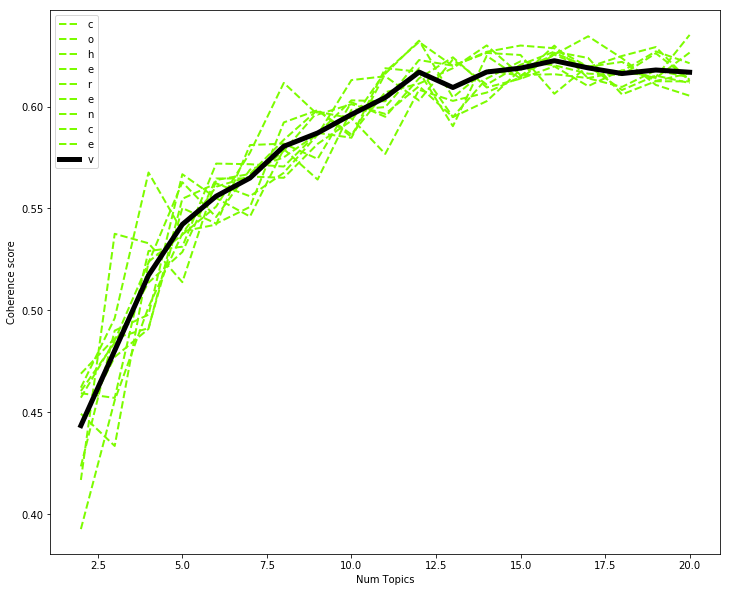

In [21]:
# Show graph

x = range(start, limit, step)

plt.figure(figsize=(12,10))

for c in coherence_val:
    plt.plot(x, c, '--', color = 'lawngreen', linewidth = 2)
plt.plot(x, coherence_w, '-', color = 'black', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_w):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.443528
Num Topics = 3  has Coherence Value of 0.48033
Num Topics = 4  has Coherence Value of 0.517263
Num Topics = 5  has Coherence Value of 0.542195
Num Topics = 6  has Coherence Value of 0.556021
Num Topics = 7  has Coherence Value of 0.564933
Num Topics = 8  has Coherence Value of 0.580484
Num Topics = 9  has Coherence Value of 0.587019
Num Topics = 10  has Coherence Value of 0.59609
Num Topics = 11  has Coherence Value of 0.604414
Num Topics = 12  has Coherence Value of 0.616883
Num Topics = 13  has Coherence Value of 0.609329
Num Topics = 14  has Coherence Value of 0.616931
Num Topics = 15  has Coherence Value of 0.618823
Num Topics = 16  has Coherence Value of 0.622467
Num Topics = 17  has Coherence Value of 0.618943
Num Topics = 18  has Coherence Value of 0.616177
Num Topics = 19  has Coherence Value of 0.617914
Num Topics = 20  has Coherence Value of 0.616817


In [23]:
# Melihat index yang memiliki nilai terbesar
num_topics = np.argmax(coherence_w)+2
num_topics

16

In [15]:
#Num topic menyesuaikan hasil dari nilai coherence paling tinggi
#LDA Model Gensim
num_topics=16
optimal_model_gensim = LdaModel(corpus=corpus_tfidf,
                 num_topics=num_topics,
                 id2word=dictionary,
                 per_word_topics=True)

In [16]:
%matplotlib inline

lda_display = pyLDAvis.sklearn.prepare(optimal_model_gensim,wiki_tf, tf_vectorizer, sort_topics=False)
lda_display

AttributeError: module 'pyLDAvis' has no attribute 'sklearn'